In [1]:
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
import opendatasets as od
from pathlib import Path
from collections import Counter
import splitfolders
from sklearn.metrics import precision_score,recall_score

In [2]:
trans=transforms.Compose([transforms.Resize((224,224)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                         
                         ])

In [3]:
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
train_dataset.classes

['Cyst', 'Normal', 'Stone', 'Tumor']

In [4]:
classifier = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')



In [7]:
classifier.classifier[6]=nn.Linear(4096,4)


Text(0.5, 1.0, '              Normal,                Normal,                 Tumor,                Normal,                Normal,                  Cyst,                  Cyst,                 Stone,                Normal,                  Cyst,                  Cyst,                Normal,                Normal,                Normal,                 Stone,                  Cyst,                Normal,                Normal,                Normal,                  Cyst,                  Cyst,                Normal,                  Cyst,                 Tumor,                Normal,                  Cyst,                  Cyst,                Normal,                 Stone,                 Stone,                Normal,                  Cyst, ')

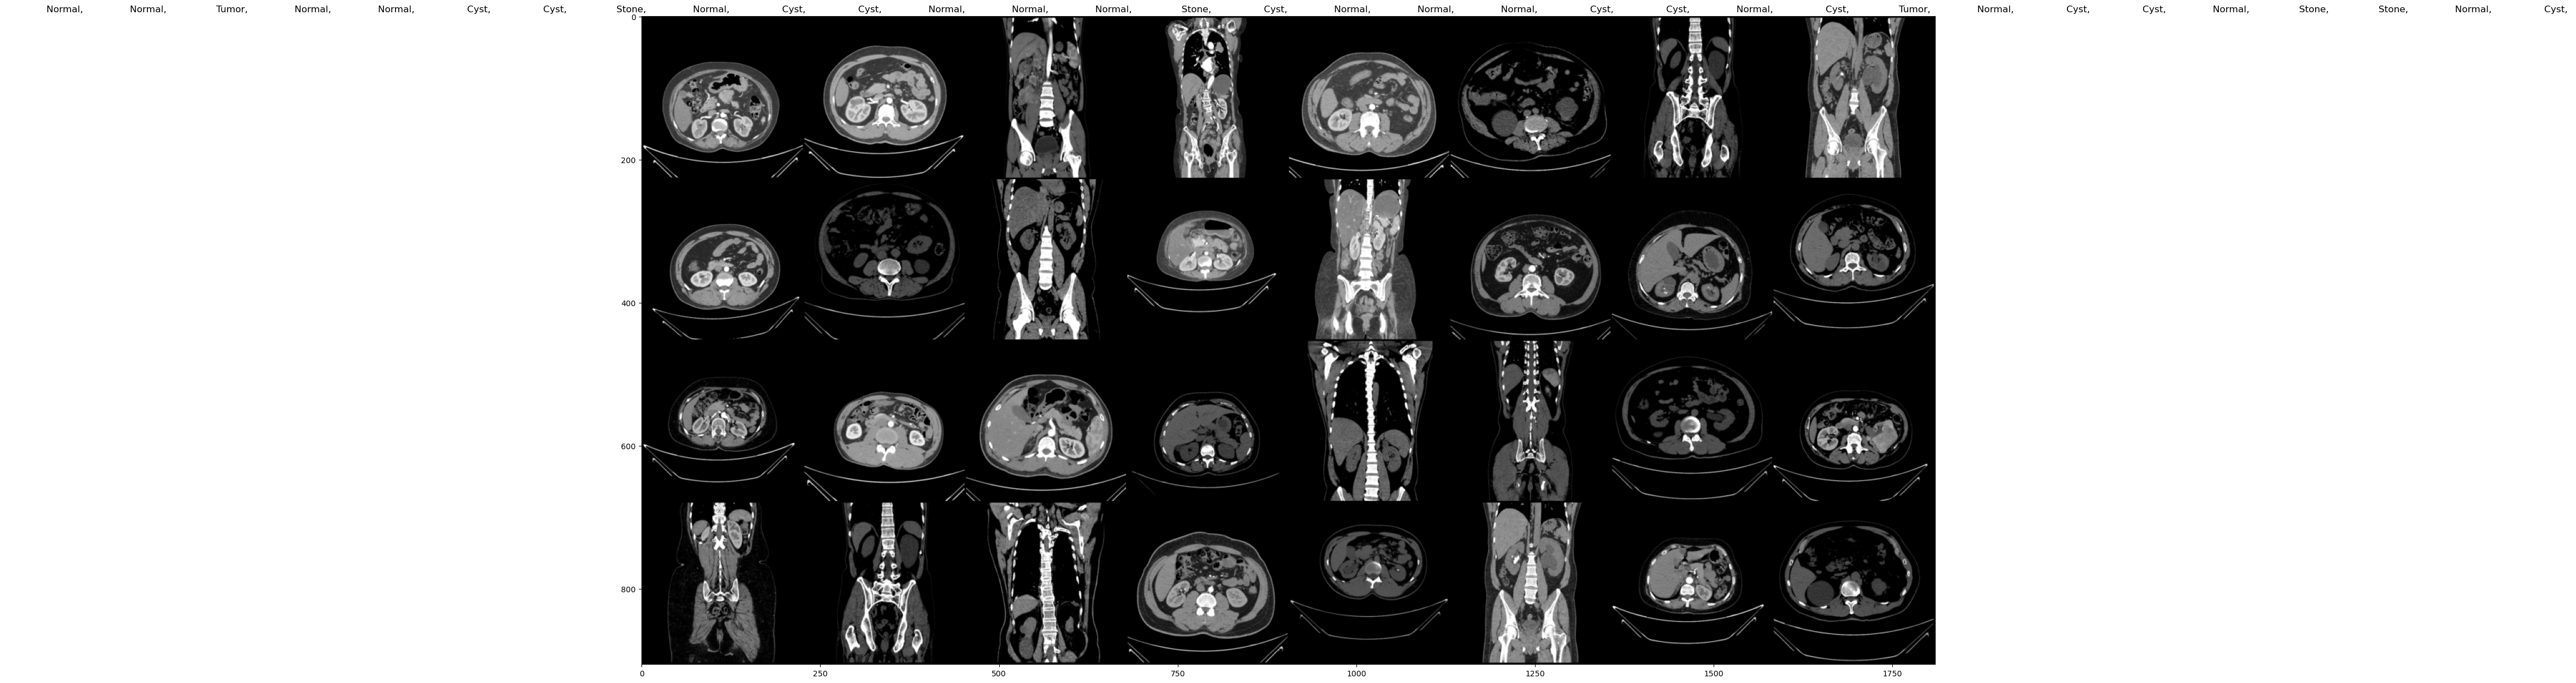

In [8]:
classes=(train_dataset.classes)
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
fig = plt.figure(figsize=(30, 30))

images,labels=next(iter(train_loader))
img = images / 2 + 0.5 
grid_img = torchvision.utils.make_grid(img)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

plt.title(' '.join('%20s, ' % classes[labels[j]] for j in range(len(labels))))


In [9]:
import pandas as pd
data=pd.read_csv('kidneyData.csv')

print(data.shape)
data

(12446, 6)


,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [10]:
category=np.unique(data['Class'])
category
id,count=np.unique(data['Class'],return_counts=True)
id,count

(array(['Cyst', 'Normal', 'Stone', 'Tumor'], dtype=object),
 array([3709, 5077, 1377, 2283], dtype=int64))

In [11]:
median=np.median(count)
class_weight=[]
for i in range(len(category)):
    print(f'{category[i]} : {median/count[i]}')
    class_weight.append(median/count[i])
class_weight=torch.FloatTensor(class_weight)

Cyst : 0.8077648961984363
Normal : 0.5901122710261966
Stone : 2.175744371822803
Tumor : 1.3123083661848445


In [13]:
def train_eval(run,optimizer,device,classifier,epochs,class_weight,train_loader,valid_loader):
   
    wandb.watch(classifier, log='all')
    classifier.train()
    classifier=classifier.to(device)
    class_weight=class_weight.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        
        train_total_accuracy=0.0
        train_total=0
        for batch_size,(image,labels) in tqdm(enumerate(train_loader)):
           
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            predicted=torch.argmax(output,dim=-1)
            
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total+=len(labels)
           
            train_total_accuracy+=(predicted == labels).sum().item() 
            
        
        wandb.log({
        'average_train_loss': train_total_loss/num_batch,
        'average_train_accuracy' :train_total_accuracy/train_total    
            },step=epoch)
        classifier.eval()
        val_total_loss=0.0
        val_total_accuracy=0.0
        val_total_precision_considering_class=0.0
        val_total_recall_considering_class=0.0
        val_total=0
        num_batch=0
        
        with torch.no_grad():
            for image,labels in tqdm(valid_loader):
                
                image=image.to(device)
                labels=labels.to(device)
                output=classifier(image)
                loss=F.cross_entropy(output,labels,weight=class_weight)
                
                _,predicted=torch.max(output,1)
                num_batch+=1
                val_total_loss+=loss.item()
                val_total_accuracy+=(predicted == labels).sum().item() 
                val_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
                val_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
               
                val_total+=len(labels)
           
            torch.save(classifier.state_dict(),'kidney_model.pt')
            artifact=wandb.Artifact('model',type='model')
            artifact.add_file('kidney_model.pt')
            run.log_artifact(artifact)
           
            
            wandb.log({
            'average_val_loss': val_total_loss/num_batch,
            'average_val_accuracy' :val_total_accuracy/val_total,    
            'average_val_precsion' :val_total_precision_considering_class/num_batch,    
            'average_val_recall' :val_total_recall_considering_class/num_batch
       
        },step=epoch)

    with torch.no_grad():
        classifier.eval()
        test_total_loss=0.0
        test_total_accuracy=0.0
        test_total_precision_considering_class=0.0
        test_total_recall_considering_class=0.0
        test_total=0
        num_batch=0        
        for image,labels in tqdm(test_loader):
            
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            loss=F.cross_entropy(output,labels,weight=class_weight)
            
            _,predicted=torch.max(output,1)
            num_batch+=1
            test_total_loss+=loss.item()
            test_total_accuracy+=(predicted == labels).sum().item() 
            test_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
            test_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
           
            test_total+=len(labels)
                
    print(f'average_test_loss: {test_total_loss/num_batch}\naverage_test_accuracy :{test_total_accuracy/test_total}\naverage_test_precsion :{test_total_precision_considering_class/num_batch}\naverage_test_recall :{test_total_recall_considering_class/num_batch}')
      


In [19]:

sweep_config={
'name' : 'parameter_tuning',
'method': 'grid',
'metric': {'name': 'val_loss','goal' :'minimize'},
'parameters':{
    'learning_rate' :
     {'values': [10**-5,10**-3]},
    'epochs': 
    {'values':[1,5,10]}
    
    },
'early_terminate':{
'type': 'hyperband',
'min_iter': 3
}
}


In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [21]:
def run_sweep(config=None):
    
    
    run=wandb.init(config=config)
    wandb_config=wandb.config
    loss=nn.CrossEntropyLoss(weight=class_weight)
    train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
    valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
    test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
    train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
    valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
    test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
    optimizer=torch.optim.Adam(classifier.parameters(),lr=wandb_config.learning_rate)
    train_eval(run,optimizer,device,classifier,wandb_config.epochs,class_weight,train_loader,valid_loader)

In [ ]:

sweep_id=wandb.sweep(sweep_config,project='kidney_classification_vgg19')
wandb.agent(sweep_id,run_sweep)
wandb.finish()

Create sweep with ID: y6ofmyqi
Sweep URL: https://wandb.ai/k9789544219/kidney_classification_vgg19/sweeps/y6ofmyqi


wandb: Agent Starting Run: gizozf6f with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05


  0%|          | 0/100 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.00s/it]
2it [00:02,  1.13s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.02s/it]
5it [00:04,  1.08it/s]
6it [00:05,  1.15it/s]
7it [00:06,  1.20it/s]
8it [00:07,  1.23it/s]
9it [00:08,  1.24it/s]
10it [00:08,  1.26it/s]
11it [00:09,  1.27it/s]
12it [00:10,  1.23it/s]
13it [00:11,  1.20it/s]
14it [00:12,  1.16it/s]
15it [00:13,  1.15it/s]
16it [00:14,  1.08it/s]
17it [00:15,  1.10it/s]
18it [00:15,  1.10it/s]
19it [00:16,  1.16it/s]
20it [00:17,  1.19it/s]
21it [00:18,  1.24it/s]
22it [00:19,  1.26it/s]
23it [00:19,  1.26it/s]
24it [00:20,  1.15it/s]
25it [00:21,  1.14it/s]
26it [00:22,  1.12it/s]
27it [00:23,  1.15it/s]
28it [00:24,  1.18it/s]
29it [00:25,  1.19it/s]
30it [00:25,  1.23it/s]
31it [00:26,  1.20it/s]
32it [00:27,  1.14it/s]
33it [00:28,  1.13it/s]
34it [00:29,  1.13it/s]
35it [00:30,  1.17it/s]
36it [00:31,  1.15it/s]
37it [00:32,  1.14it/s]
38it [00:32,  1.14it/s]
39it [00:33,  1.15it/s]
40it [00:34,  